In [3]:
import os
import pandas as pd
import pandasai as pai
from pandasai_litellm.litellm import LiteLLM

llm = LiteLLM(model="gpt‑3.5‑turbo", api_key=os.getenv("OPENAI_API_KEY"))
pai.config.set({"llm": llm})


In [4]:
df = pd.read_csv("startup_funding.csv")
print(df.head())
print(df.info())

   Sr No Date dd/mm/yyyy                  Startup Name    Industry Vertical  \
0      1      09/01/2020                        BYJU’S               E-Tech   
1      2      13/01/2020                        Shuttl       Transportation   
2      3      09/01/2020                     Mamaearth           E-commerce   
3      4      02/01/2020  https://www.wealthbucket.in/              FinTech   
4      5      02/01/2020                        Fashor  Fashion and Apparel   

                             SubVertical City  Location  \
0                             E-learning      Bengaluru   
1              App based shuttle service        Gurgaon   
2  Retailer of baby and toddler products      Bengaluru   
3                      Online Investment      New Delhi   
4            Embroiled Clothes For Women         Mumbai   

              Investors Name       InvestmentnType Amount in USD Remarks  
0    Tiger Global Management  Private Equity Round  20,00,00,000     NaN  
1  Susquehanna Growt

In [5]:
import sqlite3

# Create in-memory SQLite DB
conn = sqlite3.connect(":memory:")

# Store df into SQL
df.to_sql("funding", conn, index=False, if_exists="replace")


3044

In [7]:
# Create SQL query to count nulls per column
columns = df.columns.tolist()
query_parts = [f"SUM(CASE WHEN `{col}` IS NULL THEN 1 ELSE 0 END) AS `{col}`" for col in columns]
query = f"SELECT {', '.join(query_parts)} FROM funding;"
missing_df = pd.read_sql_query(query, conn).T
missing_df.columns = ["MissingCount"]
missing_df["Total"] = len(df)
missing_df["MissingPercent"] = round((missing_df["MissingCount"] / missing_df["Total"]) * 100, 2)
missing_df.drop(columns="Total", inplace=True)
missing_df


,MissingCount,MissingPercent
Sr No,0,0.00
Date dd/mm/yyyy,0,0.00
Startup Name,0,0.00
Industry Vertical,171,5.62
SubVertical,936,30.75
City Location,180,5.91
Investors Name,24,0.79
InvestmentnType,4,0.13
Amount in USD,960,31.54
Remarks,2625,86.24


In [8]:
# Display original dtypes
print("Original data types:")
print(df.dtypes)

# Example checks:
print("\nPossible issues:")
for col in df.columns:
    if "date" in col.lower() and not pd.api.types.is_datetime64_any_dtype(df[col]):
        print(f"- {col} may need to be converted to datetime.")
    if "amount" in col.lower() and not pd.api.types.is_numeric_dtype(df[col]):
        print(f"- {col} may need to be converted to numeric.")


Original data types:
Sr No                 int64
Date dd/mm/yyyy      object
Startup Name         object
Industry Vertical    object
SubVertical          object
City  Location       object
Investors Name       object
InvestmentnType      object
Amount in USD        object
Remarks              object
dtype: object

Possible issues:
- Date dd/mm/yyyy may need to be converted to datetime.
- Amount in USD may need to be converted to numeric.


In [16]:
import re

date_col = "Date dd/mm/yyyy"  

# Define expected pattern: dd/mm/yyyy or d/m/yyyy
pattern = re.compile(r"^(0?[1-9]|[12][0-9]|3[01])/(0?[1-9]|1[012])/[0-9]{4}$")

# Apply regex check row-wise
invalid_format_count = df[date_col].apply(lambda x: not bool(pattern.match(str(x)))).sum()
total_rows = len(df)

print(f"Dates not in 'dd/mm/yyyy' format: {invalid_format_count} out of {total_rows}")

df[date_col] = pd.to_datetime(df[date_col], dayfirst=True, errors="coerce")



Dates not in 'dd/mm/yyyy' format: 8 out of 3044


In [12]:
duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates}")


Duplicate rows: 0


In [14]:
# Clean and convert "Amount" column (you may need to rename based on dataset)
# If column is named something like 'Amount in USD', fix below

amount_col = "Amount In USD" 
if amount_col not in df.columns:
    amount_col = [c for c in df.columns if "amount" in c.lower()][0]

# Remove commas and convert to float
df[amount_col] = pd.to_numeric(df[amount_col].astype(str).str.replace(",", ""), errors="coerce")

# Overall average
avg_funding = df[amount_col].mean()
print(f"Overall average funding amount: ₹{round(avg_funding, 2)}")

# By industry vertical
industry_col = "Industry Vertical"
avg_by_industry = df.groupby(industry_col)[amount_col].mean().sort_values(ascending=False)
avg_by_industry.head(10)


Overall average funding amount: ₹18429897.27


Industry Vertical
Transportation                        979158098.5
E-Commerce & M-Commerce platform      680000000.0
Ecommerce Marketplace                 500000000.0
Car Aggregator & Retail Mobile App    500000000.0
Cab Aggregator                        400000000.0
Online Marketplace                    350071500.0
Automation                            300000000.0
B2B                                   293500000.0
Cab rental Mobile app                 225000000.0
B2B Platform                          225000000.0
Name: Amount in USD, dtype: float64

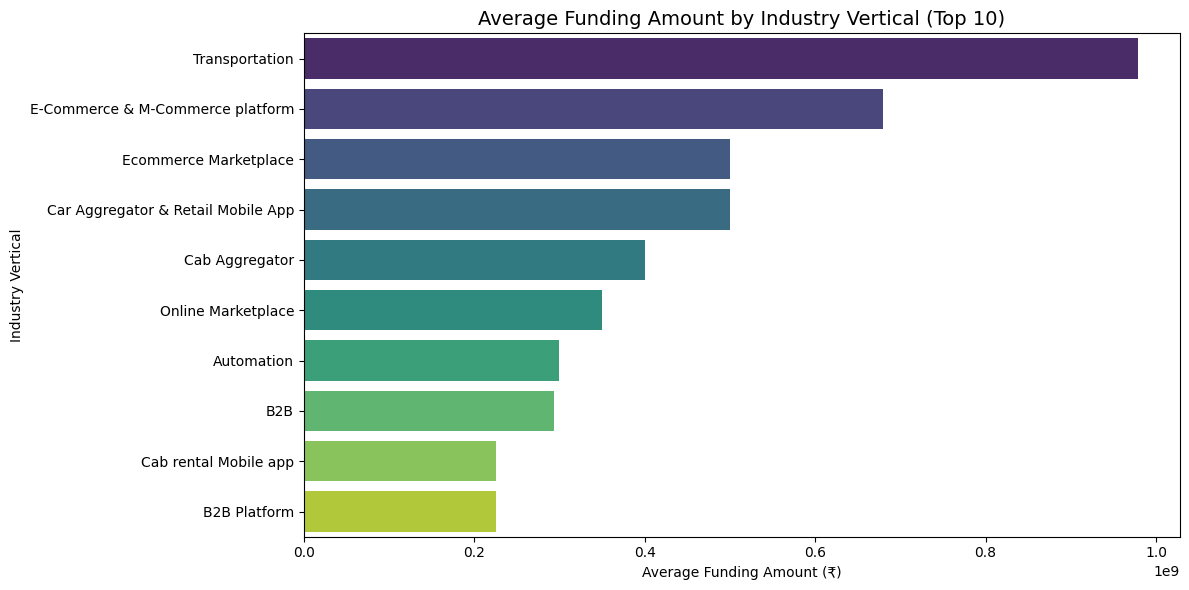

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

industry_col = "Industry Vertical"
amount_col = "Amount in USD" 

# Step 1: Clean Amount column (if not done already)
df[amount_col] = pd.to_numeric(df[amount_col].astype(str).str.replace(",", ""), errors='coerce')

# Step 2: Group by industry and calculate average
avg_funding_by_industry = df.groupby(industry_col)[amount_col].mean().sort_values(ascending=False).head(10)

# Step 3: Plot bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_funding_by_industry.values, y=avg_funding_by_industry.index, palette="viridis")
plt.title("Average Funding Amount by Industry Vertical (Top 10)", fontsize=14)
plt.xlabel("Average Funding Amount (₹)")
plt.ylabel("Industry Vertical")
plt.tight_layout()
plt.show()

In [ ]:
# Outlier detection

Q1 = df[amount_col].quantile(0.25)
Q3 = df[amount_col].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df[amount_col] < lower_bound) | (df[amount_col] > upper_bound)]

print(f"Outliers detected: {len(outliers)}")
outliers[[amount_col]].sort_values(by=amount_col, ascending=False)


Outliers detected: 283


,Amount in USD
60,3.900000e+09
651,2.500000e+09
966,1.400000e+09
830,1.400000e+09
31,1.000000e+09
...,...
2068,2.000000e+07
2511,2.000000e+07
2124,2.000000e+07
939,1.950000e+07


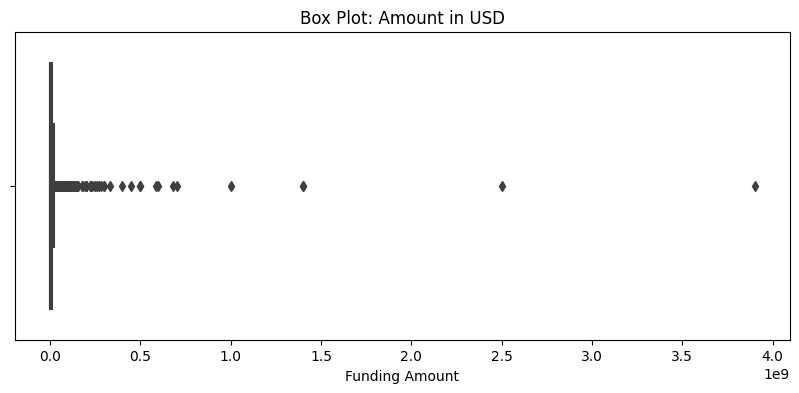

In [18]:
# Box plot for outliers

plt.figure(figsize=(10, 4))
sns.boxplot(x=df[amount_col])
plt.title("Box Plot: Amount in USD")
plt.xlabel("Funding Amount")
plt.show()


In [22]:
# Unique industry verticals

unique_industries = df[industry_col].nunique(dropna=True)
print(f"Unique Industry Verticals: {unique_industries}")


Unique Industry Verticals: 821


In [23]:
# Investment type distribution

inv_type_col = "InvestmentnType"
investment_distribution = df[inv_type_col].value_counts(dropna=True)
print(investment_distribution)


InvestmentnType
Private Equity                 1356
Seed Funding                   1355
Seed/ Angel Funding              60
Seed / Angel Funding             47
Seed\\nFunding                   30
Debt Funding                     25
Series A                         24
Seed/Angel Funding               23
Series B                         20
Series C                         14
Series D                         12
Angel / Seed Funding              8
Seed Round                        7
Pre-Series A                      4
Private Equity Round              4
Seed                              4
Seed / Angle Funding              3
pre-Series A                      2
Venture Round                     2
Equity                            2
Corporate Round                   2
Series E                          2
Series F                          2
Private                           1
Debt-Funding                      1
Term Loan                         1
Seed funding                      1
PrivateEquit

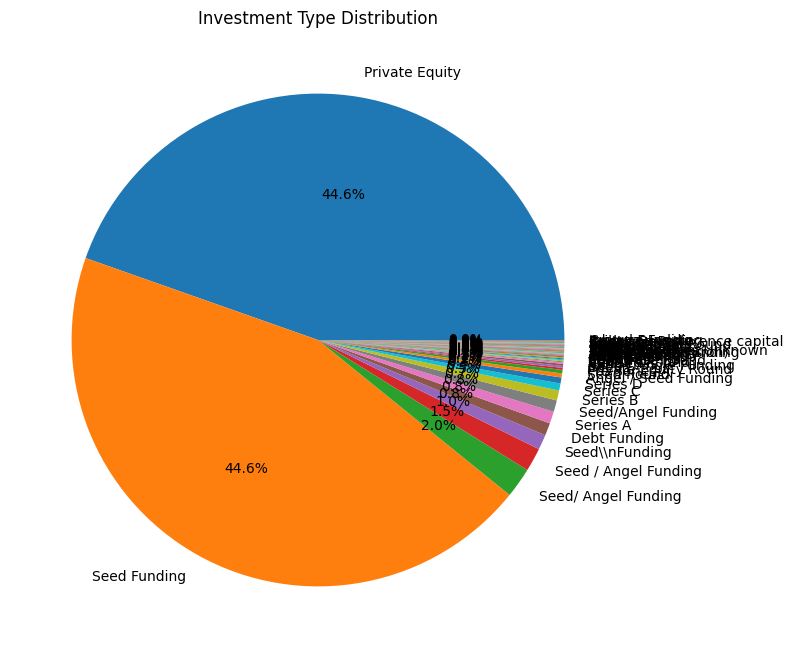

In [24]:
# Visualization for investment type distribution

investment_distribution.plot.pie(autopct="%1.1f%%", figsize=(8, 8), title="Investment Type Distribution")
plt.ylabel("")  # Removes y-axis label
plt.show()


In [25]:
# City with highest startup fundings

city_col = "City  Location"
top_city = df[city_col].value_counts().idxmax()
top_count = df[city_col].value_counts().max()
print(f"City with highest startup fundings: {top_city} ({top_count} fundings)")


City with highest startup fundings: Bangalore (700 fundings)


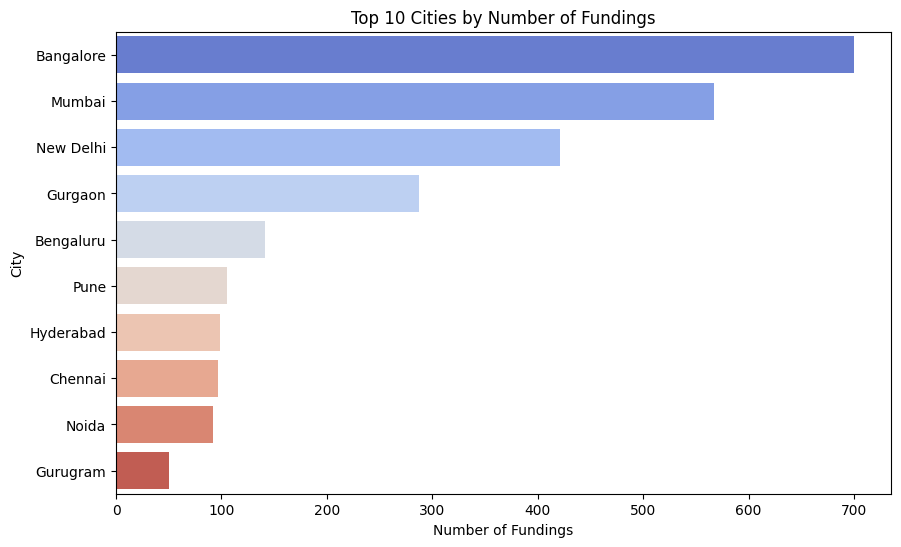

In [26]:
# Bar chart for number of startups per city

city_counts = df[city_col].value_counts().head(10)  # top 10 cities

plt.figure(figsize=(10, 6))
sns.barplot(x=city_counts.values, y=city_counts.index, palette="coolwarm")
plt.title("Top 10 Cities by Number of Fundings")
plt.xlabel("Number of Fundings")
plt.ylabel("City")
plt.show()


In [27]:
# Funding Trends Over Time (by Year)

df["Year"] = df[date_col].dt.year
funding_by_year = df.groupby("Year")[amount_col].sum().dropna().sort_index()

print("Total funding by year:")
print(funding_by_year)


Total funding by year:
Year
2015.0    8.597207e+09
2016.0    3.828089e+09
2017.0    1.042931e+10
2018.0    5.116118e+09
2019.0    9.686577e+09
2020.0    3.902073e+08
Name: Amount in USD, dtype: float64


c:\Users\Kinjal\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Kinjal\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


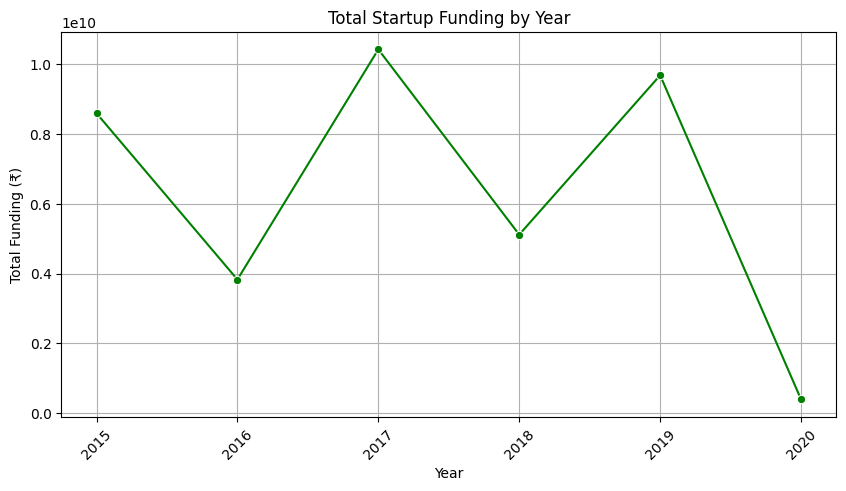

In [28]:
# Line Chart: Funding Amounts by Year

plt.figure(figsize=(10, 5))
sns.lineplot(x=funding_by_year.index, y=funding_by_year.values, marker="o", color="green")
plt.title("Total Startup Funding by Year")
plt.xlabel("Year")
plt.ylabel("Total Funding (₹)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [30]:
#  Correlation Between Investment & Industry Vertical

industry_mean = df.groupby("Industry Vertical")["Amount in USD"].mean().dropna().sort_values(ascending=False)
industry_mean.head(10)


Industry Vertical
Transportation                        979158098.5
E-Commerce & M-Commerce platform      680000000.0
Ecommerce Marketplace                 500000000.0
Car Aggregator & Retail Mobile App    500000000.0
Cab Aggregator                        400000000.0
Online Marketplace                    350071500.0
Automation                            300000000.0
B2B                                   293500000.0
Cab rental Mobile app                 225000000.0
B2B Platform                          225000000.0
Name: Amount in USD, dtype: float64

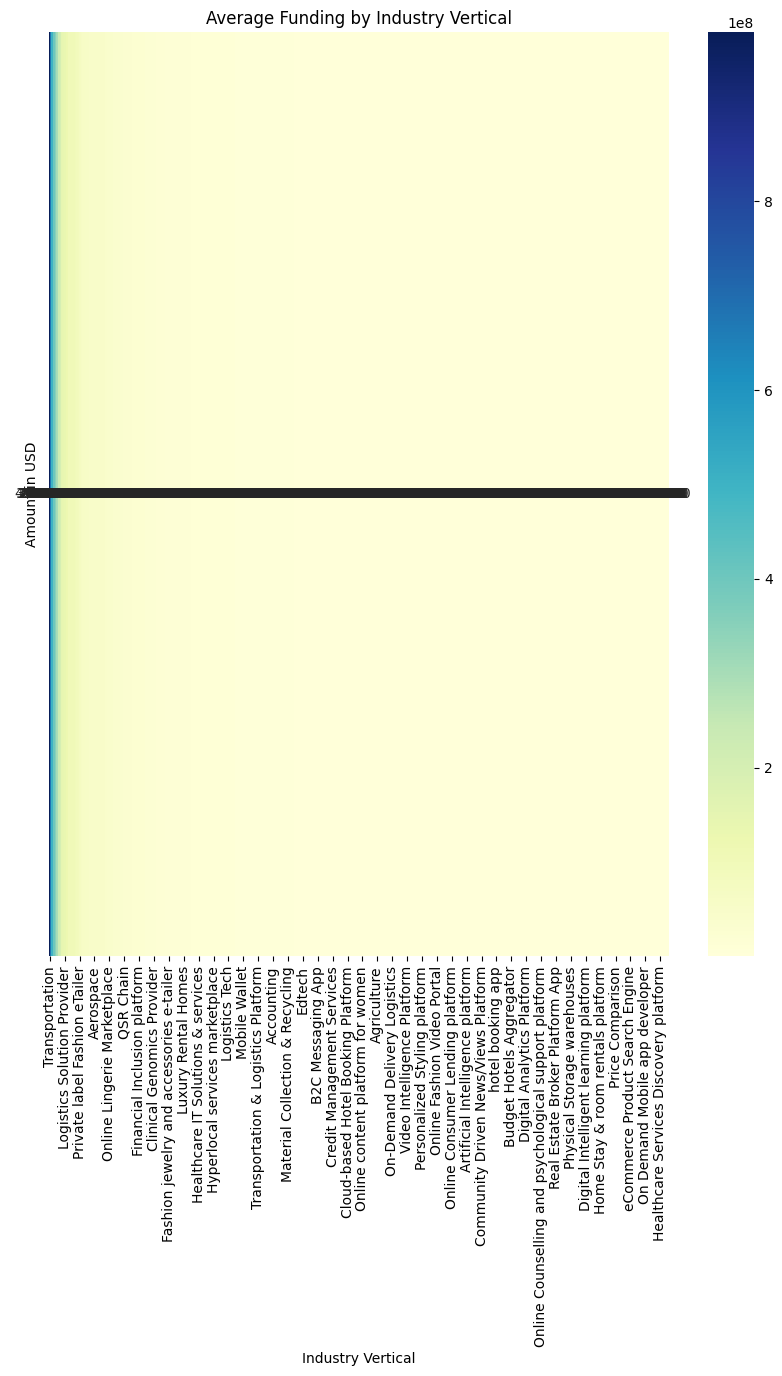

In [31]:
# Heatmap: Industry vs Avg Funding

plt.figure(figsize=(10, 12))
sns.heatmap(industry_mean.to_frame().T, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Average Funding by Industry Vertical")
plt.ylabel("")
plt.xlabel("Industry Vertical")
plt.xticks(rotation=90)
plt.show()


In [ ]:
# Investor with Most Investments & Total Amount

df["Investors Name"] = df["Investors Name"].astype(str)
# Explode comma-separated investors into multiple rows
investors_exploded = df.assign(Investor=df["Investors Name"].str.split(",")).explode("Investor")
investors_exploded["Investor"] = investors_exploded["Investor"].str.strip()

# Count and sum (Amount for each investor is not divided as per ratio in case of multiple investors)
top_investor = (
    investors_exploded.groupby("Investors Name")["Amount in USD"]
    .agg(["count", "sum"])
    .sort_values(by="count", ascending=False)
)
top_investor.head(10)


,count,sum
Investors Name,,
Undisclosed Investors,29,32106000.0
Undisclosed investors,24,291086000.0
nan,20,624105951.0
Group of Angel Investors,14,1659600.0
Kalaari Capital,13,24600000.0
Sequoia Capital,13,194850000.0
undisclosed investors,11,8390000.0
Indian Angel Network,11,6310000.0
Undisclosed,10,29165000.0


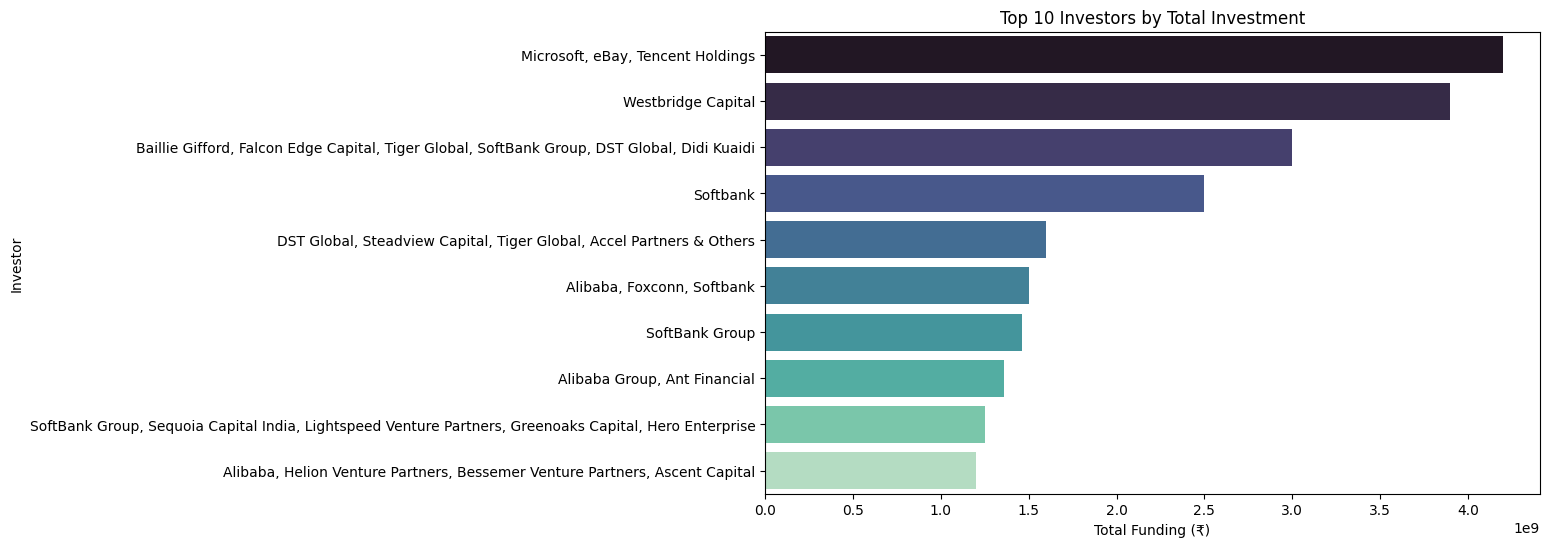

In [33]:
# Bar Chart: Total Investment by Investor

top10_investors = top_investor.sort_values(by="sum", ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top10_investors["sum"], y=top10_investors.index, palette="mako")
plt.title("Top 10 Investors by Total Investment")
plt.xlabel("Total Funding (₹)")
plt.ylabel("Investor")
plt.show()


In [34]:
# Funding Variability by Industry (Standard Deviation)

industry_std = df.groupby("Industry Vertical")["Amount in USD"].std().dropna().sort_values(ascending=False)
industry_std.head(10)


Industry Vertical
Transportation              1.947229e+09
Online Marketplace          4.948736e+08
B2B                         4.122433e+08
FinTech                     3.259681e+08
eCommerce                   2.544728e+08
ECommerce                   2.307254e+08
Last Mile Transportation    1.998991e+08
Health and Wellness         1.969168e+08
Food and Beverages          9.984444e+07
Ecommerce                   9.730066e+07
Name: Amount in USD, dtype: float64

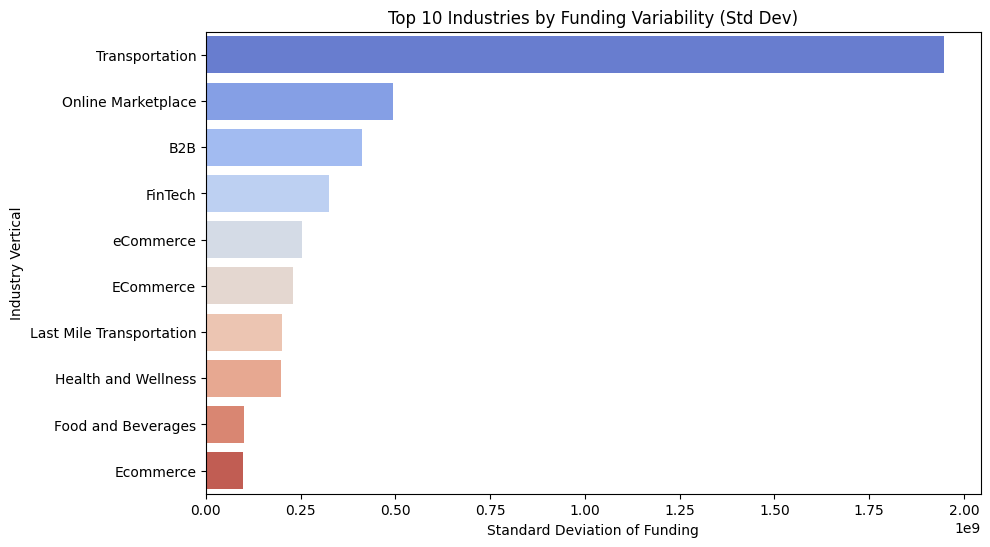

In [35]:
# Bar Chart: Funding Variability (Std Dev) by Industry

plt.figure(figsize=(10, 6))
sns.barplot(x=industry_std.head(10).values, y=industry_std.head(10).index, palette="coolwarm")
plt.title("Top 10 Industries by Funding Variability (Std Dev)")
plt.xlabel("Standard Deviation of Funding")
plt.ylabel("Industry Vertical")
plt.show()


In [36]:
# Most Funded Industry (Total)

industry_total = df.groupby("Industry Vertical")["Amount in USD"].sum().sort_values(ascending=False)
print("Most funded industry:", industry_total.idxmax(), "with ₹", industry_total.max())
industry_total.head(10)


Most funded industry: Consumer Internet with ₹ 6253084245.0


Industry Vertical
Consumer Internet                   6.253084e+09
eCommerce                           5.002533e+09
Transportation                      3.916632e+09
Technology                          2.229708e+09
Finance                             1.971438e+09
ECommerce                           1.878798e+09
FinTech                             1.220711e+09
E-Commerce                          1.008110e+09
Online Marketplace                  7.001430e+08
E-Commerce & M-Commerce platform    6.800000e+08
Name: Amount in USD, dtype: float64

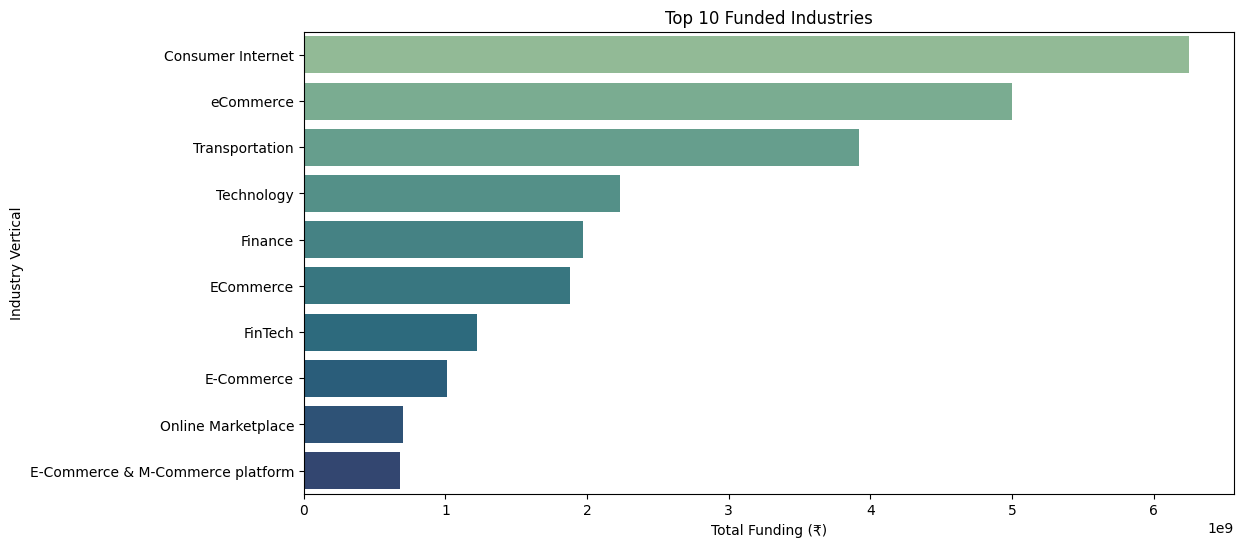

In [37]:
# Bar Chart: Total Funding by Industry

plt.figure(figsize=(12, 6))
sns.barplot(x=industry_total.head(10).values, y=industry_total.head(10).index, palette="crest")
plt.title("Top 10 Funded Industries")
plt.xlabel("Total Funding (₹)")
plt.ylabel("Industry Vertical")
plt.show()


In [38]:
# Comparative Analysis: City vs Industry

grouped = df.groupby(["City  Location", "Industry Vertical"])["Amount in USD"].sum().unstack().fillna(0)
grouped.head()


Industry Vertical,eCommerce,Consumer Internet,E-Commerce,Cloud Based Collaboration platform,Custom Merchandize platform,Enterprise Communication Platform,Finance,Food & Beverage,Food Customer analytics platform,Global Healthcare products,...,\\xc2\\xa0Online Jewellery Store,\\xc2\\xa0Contact Center Software Platform,\\xc2\\xa0Fashion Info Aggregator App,\\xc2\\xa0Online Grocery Delivery,\\xc2\\xa0Pre-School Chain,\\xc2\\xa0Premium Loyalty Rewards Point Management,\\xc2\\xa0Casual Dining restaurant Chain,\\xc2\\xa0Online Study Notes Marketplace,\\xc2\\xa0Warranty Programs Service Administration,\\xc2\\xa0News Aggregator mobile app
City Location,,,,,,,,,,,,,,,,,,,,,
Agra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ahemadabad,0.0,114811.0,6230000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ahemdabad,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ahmedabad,12098000.0,58173000.0,0.0,100000.0,1000000.0,0.0,4700000.0,0.0,300000.0,16000000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Amritsar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


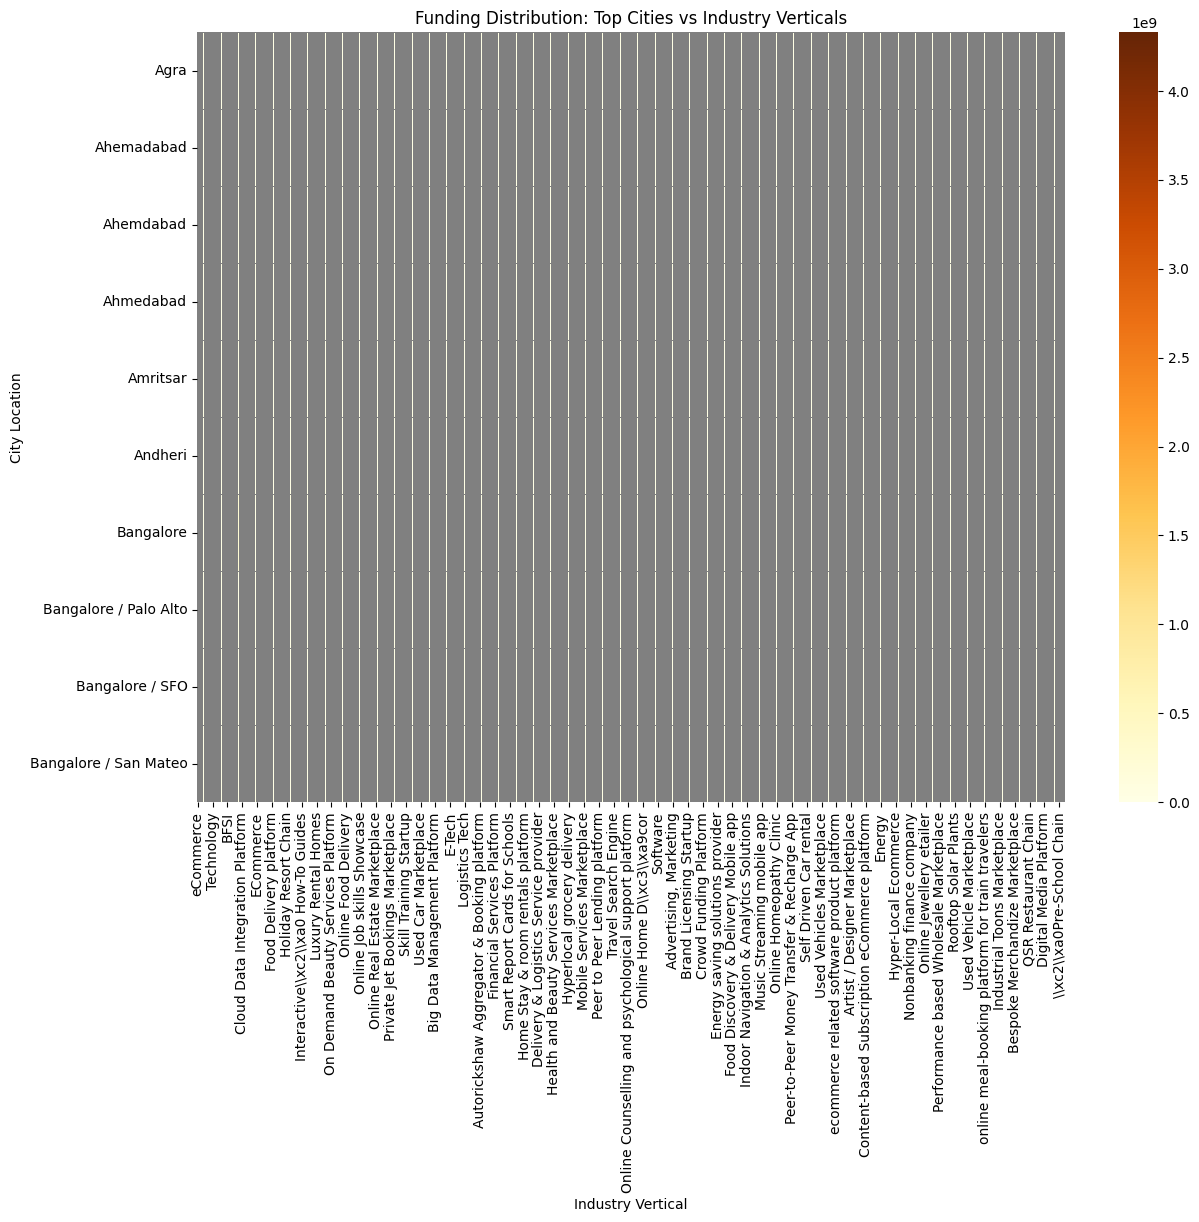

In [39]:
#  Heatmap: Funding Amount by City & Industry

plt.figure(figsize=(14, 10))
sns.heatmap(grouped.head(10), cmap="YlOrBr", linewidths=0.5, linecolor="gray")
plt.title("Funding Distribution: Top Cities vs Industry Verticals")
plt.xlabel("Industry Vertical")
plt.ylabel("City Location")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()
